<a href="https://colab.research.google.com/github/mehadisaki/Sales-Forecasting-model-development-/blob/main/Data_Quality_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
import itertools
import statsmodels.api as sm
#from matplotlib.pylab import rcPara

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, mse
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults



from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



In [18]:
plt.rcParams['figure.figsize'] = 10, 6

Read Data

In [25]:
url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/TV%20Delivery_2016-2022.xlsx?raw=true'
# taking link from view raw'

## indexing with datetime
df =pd.read_excel(url,index_col='Month',parse_dates=['Month'])
df.sort_index(inplace = True)
indexedDataset =  df.loc[df["SIZE"] == "32\" ( 813 mm )"]
#indexedDataset= indexedDataset['Delivery']
indexedDataset.head()

,SIZE,Year,Delivery
Month,,,
2016-01-01,"32"" ( 813 mm )",2016,4513
2016-02-01,"32"" ( 813 mm )",2016,5225
2016-03-01,"32"" ( 813 mm )",2016,5583
2016-04-01,"32"" ( 813 mm )",2016,5493
2016-05-01,"32"" ( 813 mm )",2016,4864


# Plot the time series


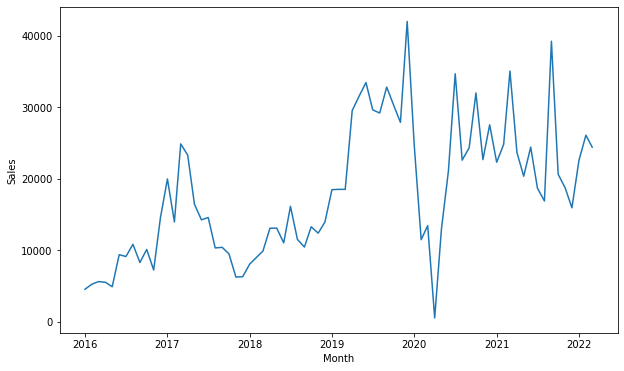

In [26]:
## plot graph
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(indexedDataset['Delivery'])

# Checking data quality

In [28]:
#Determine rolling statistics
rolmean = indexedDataset['Delivery'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset['Delivery'].rolling(window=12).std()
print(rolmean,rolstd)

Month
2016-01-01             NaN
2016-02-01             NaN
2016-03-01             NaN
2016-04-01             NaN
2016-05-01             NaN
                  ...     
2021-11-01    24329.750000
2021-12-01    23362.250000
2022-01-01    23382.250000
2022-02-01    23490.000000
2022-03-01    22602.583333
Name: Delivery, Length: 75, dtype: float64 Month
2016-01-01            NaN
2016-02-01            NaN
2016-03-01            NaN
2016-04-01            NaN
2016-05-01            NaN
                 ...     
2021-11-01    6746.335910
2021-12-01    7072.022793
2022-01-01    7069.022629
2022-02-01    7101.810243
2022-03-01    6126.226697
Name: Delivery, Length: 75, dtype: float64


###Stationary

Plot rolling statistics

For time series to be stationary, need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. 

In [41]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

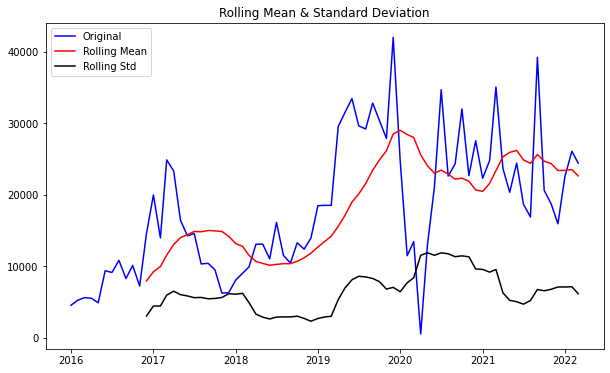

Results of Dickey Fuller Test:
Test Statistic                 -3.519458
p-value                         0.007501
#Lags Used                      0.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [42]:
test_stationarity(indexedDataset['Delivery'])

### Augmented Dickey–Fuller test

In [30]:
# Augmented Dickey–Fuller test

print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Delivery'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -3.519458
p-value                         0.007501
#Lags Used                      0.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [ ]:
For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is <0.05. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment  not stationary

In [34]:
! pip install pmdarima
import pmdarima as pm
from pmdarima import arima

In [39]:


#using pmdarima package
arima.ADFTest(alpha=0.05, k=2).is_stationary(indexedDataset['Delivery'])
#

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  after removing the cwd from sys.path.


(0.14762375651245171, True)

In [38]:
arima.KPSSTest(alpha=0.05).should_diff(indexedDataset['Delivery'])

(0.01, True)

#Transformation


## Log transformation

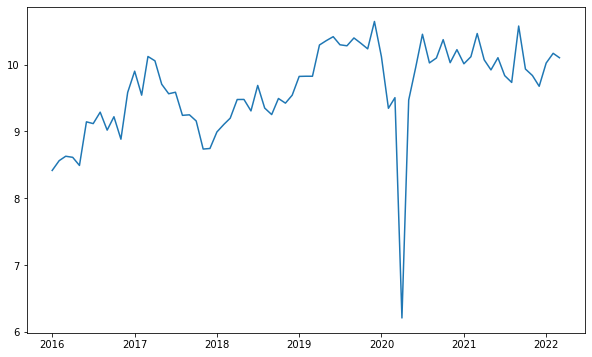

In [44]:
#Estimating trend
indexedDataset = indexedDataset['Delivery']
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

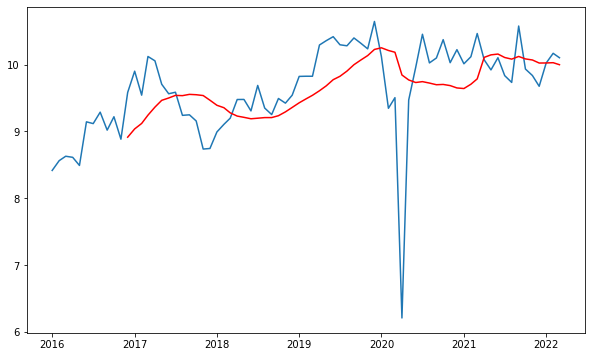

In [45]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

subtraction one from the other should remove the trend component of both. Its like:

`logscaleL=stationarypart(L1)+trend(LT) `
`movingavgoflogscaleA=stationarypart(A1)+trend(AT)`

`resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT)`





In [47]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

Month
2016-12-01    0.670003
2017-01-01    0.864056
2017-02-01    0.423541
2017-03-01    0.877924
2017-04-01    0.692477
2017-05-01    0.240737
2017-06-01    0.063431
2017-07-01    0.047099
2017-08-01   -0.294907
2017-09-01   -0.306067
Name: Delivery, dtype: float64

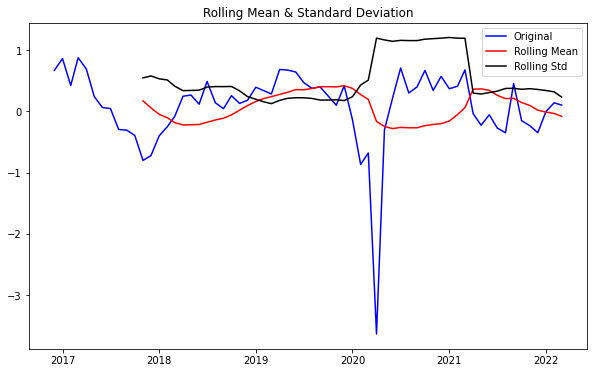

Results of Dickey Fuller Test:
Test Statistic                 -4.715296
p-value                         0.000079
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [48]:
test_stationarity(datasetLogScaleMinusMovingAverage)